# Softmax classifier vs MLP

In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, reciprocal, randint
import pandas as pd
import numpy as np
import types

In [2]:
import skorch, torch
skorch.__version__, torch.__version__

('0.3.0', '0.4.1.post2')

In [3]:
from prototype_data import get_dataset
%run prototype_plots.py

Using TensorFlow backend.


## Load results and data
old Runs: 
- mnist 13,26, 27
- cifar: 14,15

Runs 
- zuado 36,38,
- cifar 40

In [4]:
exp_id=41
results = pd.read_pickle('SoftmaxVsMLPInception/%d/results.pkl'%exp_id)
config = pd.read_json('SoftmaxVsMLPInception/%d/config.json'%exp_id, typ=dict)
print(config)

cuda                  False
data_name           cifar10
early_stopping          100
lr_init              0.0001
max_epochs              600
max_iter                200
n_hparams                10
n_jobs                   20
seed              662120624
train_size             1000
dtype: object


In [5]:
random_seed = config['seed']
np.random.seed(random_seed)

In [6]:
data_name = config['data_name']
data = get_dataset(data_name, random_seed=random_seed)

In [7]:
X_imgs, X, y = data.gen_data(plot=False)
skf, _ = data.splitters(train_size=config['train_size'])
train, test = list(skf.split(X,y))[0]
scaler = StandardScaler()
X = scaler.fit(X[train]).transform(X)

In [8]:
nn_results = results['results']
nn_results.param_module__nonlin = \
    nn_results.param_module__nonlin.apply(
    lambda v: v.__name__ if type(v) == types.FunctionType else 'none')
search = results['search']

In [9]:
# nn_results = results['nn_results']
# nntanh_search = results['nntanh_search']
# sm_results = results['sm_results']
# sm_search = results['sm_search']
select = lambda df, column, val: df.loc[df[column] == val]
geq = lambda df, column, val: df.loc[df[column] >= val]

In [10]:
nn_results[['param_module__nonlin', 'param_module__num_units',
            'param_optimizer__weight_decay',
            'mean_test_score', 'std_test_score', 
            'mean_train_score', 'std_train_score']]

param_module__nonlin param_module__num_units param_optimizer__weight_decay  \
0                  none                       0                         1e-05   
1                  none                       0                   0.000129155   
2                  none                       0                     0.0016681   
3                  none                       0                     0.0215443   
4                  none                       0                      0.278256   
5                  none                       0                       3.59381   
6                  none                       0                       46.4159   
7                  none                       0                       599.484   
8                  none                       0                       7742.64   
9                  none                       0                        100000   
10                 relu                    2048                         1e-05   
11                 relu                    2048                   0.000129155   
12                 relu                    2048                     0.0016681   
13                 relu                    2048                     0.0215443   
14                 relu                    2048                      0.278256   
15                 relu                    2048                       3.59381   
16                 relu                    2048                       46.4159   
17                 relu                    2048                       599.484   
18                 relu                    2048                       7742.64   
19                 relu                    2048                        100000   
20                 tanh                    2048                         1e-05   
21                 tanh                    2048                   0.000129155   
22                 tanh                    2048                     0.0016681   
23                 tanh                    2048                     0.0215443   
24                 tanh                    2048                      0.278256   
25                 tanh                    2048                       3.59381   
26                 tanh                    2048                       46.4159   
27                 tanh                    2048                       599.484   
28                 tanh                    2048                       7742.64   
29                 tanh                    2048                        100000   
30              sigmoid                    2048                         1e-05   
31              sigmoid                    2048                   0.000129155   
32              sigmoid                    2048                     0.0016681   
33              sigmoid                    2048                     0.0215443   
34              sigmoid                    2048                      0.278256   
35              sigmoid                    2048                       3.59381   
36              sigmoid                    2048                       46.4159   
37              sigmoid                    2048                       599.484   
38              sigmoid                    2048                       7742.64   
39              sigmoid                    2048                        100000   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
0             0.698           0.008             0.911            0.039  
1             0.698           0.008             0.911            0.039  
2             0.698           0.008             0.911            0.039  
3             0.702           0.010             0.911            0.039  
4             0.696           0.010             0.902            0.044  
5             0.689           0.003             0.854            0.014  
6             0.602           0.042             0.692            0.040  
7             0.589           0.031             0.670            0.042  
8             0.203     

## Results

In [11]:
# t = sm_results.pivot_table(values='mean_test_score', index=['param_C'])
# terr = sm_results.pivot_table(values='std_test_score', index=['param_C'])
# t.plot(yerr=terr, logx=True, marker='+')
# idx = sm_results.mean_test_score.idxmax()
# sm_results.loc[idx:idx][['param_C',
#                          'mean_test_score', 'std_test_score', 
#                          'mean_train_score', 'std_train_score']]

param_module__nonlin param_module__num_units param_optimizer__weight_decay  \
32              sigmoid                    2048                     0.0016681   
3                  none                       0                     0.0215443   
13                 relu                    2048                     0.0215443   
20                 tanh                    2048                         1e-05   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
32            0.712           0.012             0.884            0.066  
3             0.702           0.010             0.911            0.039  
13            0.729           0.009             0.947            0.009  
20            0.724           0.012             0.934            0.024

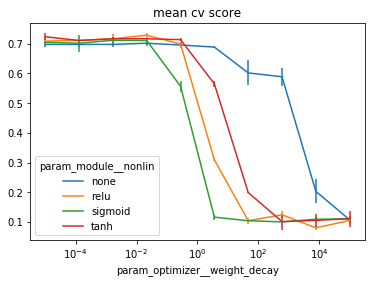

In [12]:
df = nn_results
t=df.pivot_table('mean_test_score', 
                 index='param_optimizer__weight_decay',
                 columns='param_module__nonlin')
terr=df.pivot_table('std_test_score', 
                    index='param_optimizer__weight_decay',
                    columns='param_module__nonlin')
t.plot(yerr=terr, title='mean cv score', logx=True)

idx = []
for param in set(df.param_module__nonlin):
    idx.append(select(nn_results, 'param_module__nonlin', param).mean_test_score.idxmax())

df.loc[idx][
    ['param_module__nonlin', 'param_module__num_units',
     'param_optimizer__weight_decay',
    'mean_test_score', 'std_test_score', 
    'mean_train_score', 'std_train_score']]

### Test set scores

In [13]:
# best_nn = nntanh_search.best_estimator_
# best_sm = sm_search.best_estimator_
best_nn = search.best_estimator_
'NN: ', best_nn.score(X[test],y[test]), #'softmax: ', best_sm.score(X[test],y[test])

('NN: ', 0.7583)